In [5]:
import importlib
import segment
importlib.reload(segment)
from segment import load_report_with_images, get_docs_with_ocr
from doctr.models import ocr_predictor
import os
import pickle

CACHE_PATH = "../data/cache/political_report.pkl"

if os.path.exists(CACHE_PATH):
    print("Loading docs from cache...")
    with open(CACHE_PATH, "rb") as f:
        docs = pickle.load(f)
    print("Loaded from cache:", len(docs))
else:
    ocr_model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True).cuda()
    items = load_report_with_images(limit=3000, json_dir="../data/DITrans-EMNLP/political_report/jsons/", img_dir ="../data/DITrans-EMNLP/political_report/imgs/")
    print("Loaded:", len(items))
    docs = get_docs_with_ocr(items, ocr_model)
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    with open(CACHE_PATH, "wb") as f:
        pickle.dump(docs, f)
    print("Saved docs to cache:", CACHE_PATH)

docs = [doc for doc in docs if len(doc['segments']) < 120]
print("Processed Docs:", len(docs))
docs_political_reports = docs

Loading docs from cache...
Loaded from cache: 1397
Processed Docs: 1389


In [6]:
import importlib
import segment
importlib.reload(segment)
from segment import load_report_with_images, get_docs_with_ocr
from doctr.models import ocr_predictor
import os
import pickle

CACHE_PATH = "../data/cache/news.pkl"

if os.path.exists(CACHE_PATH):
    print("Loading docs from cache...")
    with open(CACHE_PATH, "rb") as f:
        docs = pickle.load(f)
    print("Loaded from cache:", len(docs))
else:
    ocr_model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True).cuda()
    items = load_report_with_images(limit=3000, json_dir="../data/DITrans-EMNLP/news/jsons/", img_dir ="../data/DITrans-EMNLP/news/imgs/")
    print("Loaded:", len(items))
    docs = get_docs_with_ocr(items, ocr_model)
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    with open(CACHE_PATH, "wb") as f:
        pickle.dump(docs, f)
    print("Saved docs to cache:", CACHE_PATH)

docs = [doc for doc in docs if len(doc['segments']) < 120]
print("Processed Docs:", len(docs))
docs_news = docs

Loading docs from cache...
Loaded from cache: 486
Processed Docs: 486


In [7]:
import importlib
import segment
importlib.reload(segment)
from segment import load_report_with_images, get_docs_with_ocr
from doctr.models import ocr_predictor
import os
import pickle

CACHE_PATH = "../data/cache/advertisement.pkl"

if os.path.exists(CACHE_PATH):
    print("Loading docs from cache...")
    with open(CACHE_PATH, "rb") as f:
        docs = pickle.load(f)
    print("Loaded from cache:", len(docs))
else:
    ocr_model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True).cuda()
    items = load_report_with_images(limit=3000, json_dir="../data/DITrans-EMNLP/advertisement/jsons/", img_dir ="../data/DITrans-EMNLP/advertisement/imgs/")
    print("Loaded:", len(items))
    docs = get_docs_with_ocr(items, ocr_model)
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    with open(CACHE_PATH, "wb") as f:
        pickle.dump(docs, f)
    print("Saved docs to cache:", CACHE_PATH)

docs = [doc for doc in docs if len(doc['segments']) < 120]
print("Processed Docs:", len(docs))
docs_advertisements = docs

Loading docs from cache...
Loaded from cache: 390
Processed Docs: 390


In [11]:
import os
import json
import random
import shutil

def convert_segments_to_yolo_with_split(
    docs,
    out_dir="../data/full_data",
    val_ratio=0.1
):

    # 1. Create base dirs
    images_dir = f"{out_dir}/images"
    labels_dir = f"{out_dir}/labels"
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    # 2. Convert and save YOLO data (no split yet)
    for idx, doc in enumerate(docs):
        img_path = doc["image_path"]
        segments = doc["segments"]
        H, W = doc["dimensions"]

        # Copy image
        img_out = f"{images_dir}/{idx}.jpg"
        shutil.copy2(img_path, img_out)

        # Write YOLO label
        label_out = f"{labels_dir}/{idx}.txt"
        with open(label_out, "w") as f:
            for seg in segments:
                box = seg["box"]

                x_min = box["x_min"]
                y_min = box["y_min"]
                x_max = box["x_max"]
                y_max = box["y_max"]

                x_center = (x_min + x_max) / 2 / W
                y_center = (y_min + y_max) / 2 / H
                w = (x_max - x_min) / W
                h = (y_max - y_min) / H

                f.write(f"0 {x_center} {y_center} {w} {h}\n")

    print("[1] YOLO labels + images created:", out_dir)

    # ---------------------------
    # 3. Now do train/val split
    # ---------------------------
    print("[2] Doing train/val split...")

    train_img_dir = f"{out_dir}/train/images"
    train_lbl_dir = f"{out_dir}/train/labels"
    val_img_dir = f"{out_dir}/val/images"
    val_lbl_dir = f"{out_dir}/val/labels"

    os.makedirs(train_img_dir, exist_ok=True)
    os.makedirs(train_lbl_dir, exist_ok=True)
    os.makedirs(val_img_dir, exist_ok=True)
    os.makedirs(val_lbl_dir, exist_ok=True)

    img_files = sorted(os.listdir(images_dir))
    random.shuffle(img_files)

    n_val = int(len(img_files) * val_ratio)
    val_files = img_files[:n_val]
    train_files = img_files[n_val:]

    # Move into train/val folders
    for file_list, split in [(train_files, "train"), (val_files, "val")]:
        for file in file_list:
            img_src = f"{images_dir}/{file}"
            lbl_src = f"{labels_dir}/{file.replace('.jpg', '.txt')}"

            img_dst = f"{out_dir}/{split}/images/{file}"
            lbl_dst = f"{out_dir}/{split}/labels/{file.replace('.jpg', '.txt')}"

            shutil.copy2(img_src, img_dst)
            shutil.copy2(lbl_src, lbl_dst)

    print("[3] Train/val split finished!")
    print(f"Train: {len(train_files)} images")
    print(f"Val:   {len(val_files)} images")


convert_segments_to_yolo_with_split(docs_political_reports + docs_news + docs_advertisements, out_dir="../data/dit-trans-proc/")

[1] YOLO labels + images created: ../data/dit-trans-proc/
[2] Doing train/val split...
[3] Train/val split finished!
Train: 2039 images
Val:   226 images


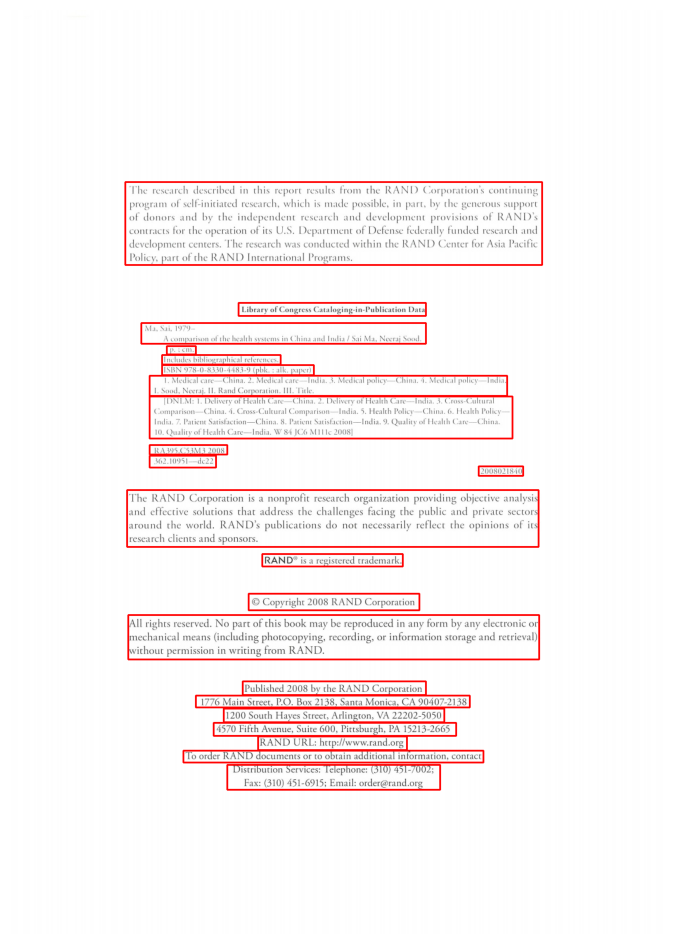

In [16]:
import cv2
import matplotlib.pyplot as plt

def show_yolo_image(img_path, label_path):
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found:", img_path)
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img.shape

    # Read YOLO label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        cls, x_center, y_center, w, h = map(float, line.strip().split())

        # Convert YOLO → pixel coords
        x_center *= W
        y_center *= H
        w *= W
        h *= H

        x_min = int(x_center - w/2)
        y_min = int(y_center - h/2)
        x_max = int(x_center + w/2)
        y_max = int(y_center + h/2)

        # Draw box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255,0,0), 2)

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

img_id = "90"  # or any index

img_path = f"../data/dit-trans-proc/train/images/{img_id}.jpg"
label_path = f"../data/dit-trans-proc/train/labels/{img_id}.txt"

show_yolo_image(img_path, label_path)

In [20]:
!yolo detect train \
    data=data/dit-trans-proc/dit-trans-proc.yaml \
    model=models/yolo.pt \
    imgsz=1024 \
    batch=96 \
    epochs=50 \
    device=0,1,2,3 \
    workers=8

In [19]:
from ultralytics import YOLO

model = YOLO("../models/yolo.pt")
model.info()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/compiling-ganesh/24m0797/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv10m-doclayout summary: 636 layers, 19973596 parameters, 19973580 gradients, 68.0 GFLOPs


(636, 19973596, 19973580, 68.0227584)

In [ ]:
# train_yolo.py
from doclayout_yolo import YOLOv10

def train_yolo():
    # Load pretrained doclayout model
    model = YOLOv10("../models/yolo.pt")   # YOLOv10m-doclayout

    model.train(
        data="../data/dit-trans-proc/dit-trans-proc.yaml",

        # ==========================
        # 🔥 4× L40 GPU OPTIMIZED
        # ==========================
        device="0,1,2,3",      # multi-GPU
        imgsz=1024,
        epochs=50,

        batch=64,

        # Learning rate scheduling
        warmup_epochs=3,
        patience=15,

        # Logging + saving
        project="dit_trans",
        name="yolov10m_doclayout",
        save_period=1,

        single_cls=True,
        save_json=True,
    
        plots=True,
        save=True,
        val=True,
    )

    print("🔥 Training complete!")

train_yolo()

Ultralytics YOLOv0.0.4 🚀 Python-3.13.5 torch-2.9.1+cu128 CUDA:0 (NVIDIA L40S, 45468MiB)
                                                          CUDA:1 (NVIDIA L40S, 45468MiB)
                                                          CUDA:2 (NVIDIA L40S, 45468MiB)
                                                          CUDA:3 (NVIDIA L40S, 45468MiB)
engine/trainer: task=detect, mode=train, model=../models/yolo.pt, data=../data/dit-trans-proc/dit-trans-proc.yaml, epochs=50, time=None, patience=15, batch=64, imgsz=1024, save=True, save_period=1, val_period=1, cache=False, device=0,1,2,3, workers=8, project=dit_trans, name=yolov10m_doclayout, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save_hybrid=False, conf=None, i

wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in /home/compiling-ganesh/24m0797/workspace/doctr-dit/notebooks/wandb/offline-run-20251126_101950-o0mgqs4g


Overriding model.yaml nc=10 with nc=1
Transferred 966/1050 items from pretrained weights
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks skipped ⚠️, offline and unable to download YOLOv8n. Setting 'amp=True'. If you experience zero-mAP or NaN losses you can disable AMP with amp=False.


/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:277: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:277: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:277: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python

train: WARNING ⚠️ /home/compiling-ganesh/24m0797/workspace/doctr-dit/data/dit-trans-proc/train/images/145.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.1913536 1.0420649 1.1729534 1.125281  1.1158383 1.1422107 1.1216625
 1.1487547 1.1511207 1.132253  1.1215011 1.1261437 1.1661302 1.114101
 1.1600661 1.1063203 1.1306188]


/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -2] Name or service not known>
  data = fetch_version_info()
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/data/augment.py:846: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/compiling-ganesh/24m0797/workspace/doctr-dit/data/dit-trans
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -2] Name or service not known>
  data = fetch_version_info()
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/data/augment.py:846: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -2] Name or service not known>
  data = fetch_version_info()
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no

Plotting labels to dit_trans/yolov10m_doclayout/labels.jpg... 


/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 171 weight(decay=0.0), 183 weight(decay=0.0005), 183 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to dit_trans/yolov10m_doclayout
Starting training for 50 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/50      32.9G      4.499       4.73          0      4.268      7.964  
                 Class     Images  Instances      Box(P          R      mAP50  


226
                   all        226       3903      0.126      0.108     0.0297    0.00983
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
       2/50      34.2G      2.278       1.64          0      2.216      2.443  
               

226
                   all        226       3903      0.492      0.379      0.384      0.154
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
       3/50      34.6G      1.645      1.037          0      1.707      1.399  
               

226
                   all        226       3903      0.602      0.634      0.613      0.226
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
       4/50      34.6G      1.419     0.8952          0      1.542      1.112  
               

226
                   all        226       3903      0.758        0.7      0.742      0.345
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
       5/50      33.5G      1.275     0.8097          0      1.425     0.9639  
               

226
                   all        226       3903       0.79      0.735      0.783       0.41
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
       6/50        35G      1.193     0.7734          0      1.345     0.8946  
               

226
                   all        226       3903      0.771      0.755      0.784      0.493
Saving dit_trans/yolov10m_doclayout/predictions.json...


/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/50      35.6G      1.141     0.7358          0      1.308     0.8345  
                 Class     Images  Instances      Box(P          R      mAP50  


226
                   all        226       3903      0.784      0.749      0.798      0.514
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
       8/50      32.7G      1.102     0.7091          0       1.28     0.7897  
               

226
                   all        226       3903      0.788      0.749      0.804      0.532
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
       9/50      33.5G      1.067     0.6862          0      1.238     0.7675  
               

226
                   all        226       3903      0.804      0.779      0.824      0.545
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      10/50      33.3G      1.012     0.6488          0      1.184     0.7131  
               

226
                   all        226       3903      0.824      0.778      0.829      0.556
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      11/50      33.5G      1.008     0.6469          0      1.189     0.6963  
               

226
                   all        226       3903      0.809      0.779       0.83      0.534
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      12/50      33.1G     0.9967     0.6471          0      1.156     0.6725  
               

226
                   all        226       3903      0.835      0.795      0.841      0.576
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      13/50      34.4G     0.9506     0.6169          0      1.126     0.6479  
               

226
                   all        226       3903      0.836      0.795      0.843      0.571
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      14/50      33.1G     0.9676     0.6131          0      1.145     0.6521  
               

226
                   all        226       3903      0.837      0.811      0.851      0.607
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      15/50      35.3G     0.9422     0.6023          0      1.123     0.6304  
               

226
                   all        226       3903      0.829      0.799      0.844      0.598
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      16/50      35.6G     0.9527     0.6021          0      1.124     0.6351  
               

226
                   all        226       3903      0.843      0.788      0.844      0.594
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      17/50      34.5G     0.9083     0.5773          0      1.116     0.6262  
               

226
                   all        226       3903      0.843      0.809      0.859      0.586
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      18/50      33.3G     0.9179     0.5842          0      1.087     0.5988  
               

226
                   all        226       3903      0.836      0.825      0.861      0.595
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      19/50      34.2G     0.9273     0.5695          0      1.104     0.5925  
               

226
                   all        226       3903      0.836      0.815      0.855      0.602
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      20/50      34.5G     0.8766     0.5522          0       1.05     0.5696  
               

226
                   all        226       3903      0.858      0.814      0.864      0.624
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      21/50      33.2G     0.8525     0.5438          0      1.024     0.5592  
               

226
                   all        226       3903      0.868      0.816       0.87      0.614
Saving dit_trans/yolov10m_doclayout/predictions.json...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/doclayout_yolo/engine/trainer.py:380: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      22/50      33.1G     0.8505     0.5404          0      1.032     0.5565  
               

In [21]:
!export CUDA_VISIBLE_DEVICES=0,1,2,3